In [8]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt

from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models, matutils
from wordcloud import WordCloud

In [9]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Verify that the drive is mounted
!ls # Verify that the drive is mounted
!ls /content/drive/MyDrive/M5_ALY6040

drive  sample_data
Reviews.csv


In [12]:
file_path = '/Reviews.csv'
df = pd.read_csv(file_path)

In [13]:
# View basic info
print("Total reviews:", len(df))
df.head()

Total reviews: 568454


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [14]:
# Step: Filter Data for Topic Modeling
# Keep only positive/neutral reviews (Score > 2) and first 15,000 reviews
filtered_df = df[(df['Score'] > 2) & (df['Id'] < 15000)][['Text']].dropna().copy()

print("Filtered reviews for LDA:", len(filtered_df))


Filtered reviews for LDA: 12734


In [15]:
#  Step : Clean and Preprocess Text
# Define custom stopwords
custom_stopwords = {
    'the', 'and', 'to', 'of', 'a', 'i', 'it', 'in', 'is', 'this', 'that', 'was', 'for',
    'my', 'with', 'but', 'on', 'not', 'have', 'they', 'are', 'so', 'be', 'if', 'you',
    'had', 'as', 'at', 'we', 'me', 'all', 'just', 'or', 'an', 'from', 'like', 'there',
    'would', 'what', 'when', 'out', 'about', 'up', 'more', 'one', 'do', 'no', 'get',
    'been', 'some', 'very', 'them', 'he', 'she', 'because', 'will', 'too', 'how'
}

# Initialize stemmer
stemmer = PorterStemmer()

# Define cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in custom_stopwords]  # Remove stopwords
    tokens = [stemmer.stem(word) for word in tokens]  # Apply stemming
    return " ".join(tokens)

# Apply cleaning
filtered_df['Cleaned_Text'] = filtered_df['Text'].apply(clean_text)

# Preview cleaned text
filtered_df[['Text', 'Cleaned_Text']].head()


,Text,Cleaned_Text
0,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
2,This is a confection that has been around a fe...,confect ha around few centuri light pillowi ci...
4,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...
5,I got a wild hair for taffy and ordered this f...,got wild hair taffi order five pound bag taffi...
6,This saltwater taffy had great flavors and was...,saltwat taffi great flavor soft chewi each can...


In [16]:
# Step : Convert Text to Document-Term Matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(filtered_df['Cleaned_Text'])

# Convert to Gensim corpus and dictionary
corpus = matutils.Sparse2Corpus(dtm.transpose())
id2word = {v: k for k, v in vectorizer.vocabulary_.items()}


In [17]:
# Step : Apply LDA (Latent Dirichlet Allocation)
# Set number of topics
num_topics = 5

# Train the LDA model
lda_model = models.LdaModel(
    corpus=corpus,
    num_topics=num_topics,
    id2word=id2word,
    passes=10,
    random_state=42
)

# Print the topics with top words
topics = lda_model.print_topics(num_words=10)
print("\n--- LDA Topics ---")
for idx, topic in topics:
    print(f"\nTopic {idx}: {topic}")



--- LDA Topics ---

Topic 0: 0.015*"cooki" + 0.015*"tast" + 0.014*"cracker" + 0.014*"great" + 0.013*"love" + 0.012*"product" + 0.012*"good" + 0.012*"mix" + 0.011*"make" + 0.010*"free"

Topic 1: 0.044*"br" + 0.013*"use" + 0.012*"water" + 0.010*"sugar" + 0.009*"tast" + 0.008*"product" + 0.007*"juic" + 0.007*"drink" + 0.006*"make" + 0.006*"work"

Topic 2: 0.056*"coffe" + 0.017*"cup" + 0.016*"good" + 0.015*"flavor" + 0.013*"price" + 0.012*"tast" + 0.012*"great" + 0.011*"use" + 0.010*"tri" + 0.010*"order"

Topic 3: 0.029*"dog" + 0.026*"treat" + 0.014*"food" + 0.013*"love" + 0.013*"br" + 0.010*"eat" + 0.010*"good" + 0.008*"bag" + 0.008*"organ" + 0.007*"tri"

Topic 4: 0.040*"tea" + 0.033*"flavor" + 0.027*"tast" + 0.017*"tri" + 0.015*"drink" + 0.011*"ha" + 0.010*"love" + 0.010*"sweet" + 0.009*"good" + 0.009*"great"


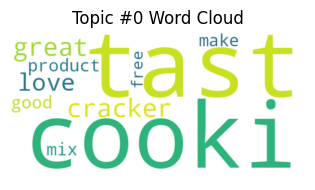

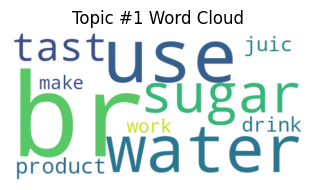

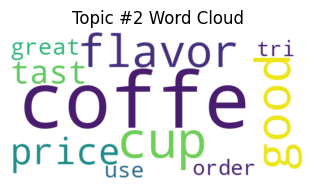

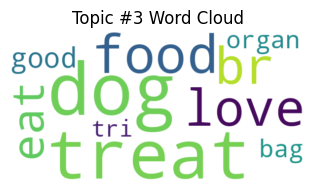

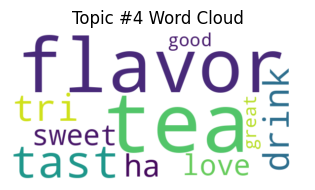

In [20]:
# Step : Generate Word Clouds for Each Topic
for i, topic in enumerate(topics):
    plt.figure(figsize=(4, 2))  # Smaller figure size
    plt.title(f"Topic #{i} Word Cloud", fontsize=12)

    # Parse topic word weights
    word_freq = {
        word.split("*")[1].strip().strip('"'): float(word.split("*")[0])
        for word in topic[1].split("+")
    }

    # Smaller WordCloud size
    wc = WordCloud(width=600, height=300, background_color='white').generate_from_frequencies(word_freq)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout()
    plt.show()

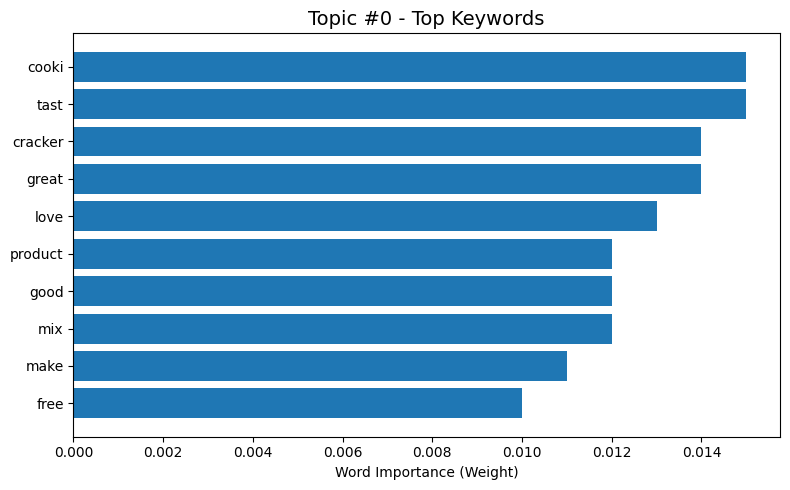

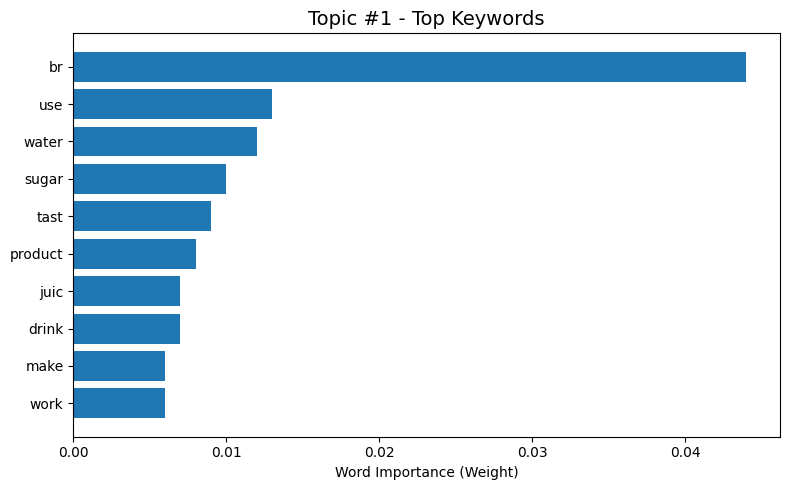

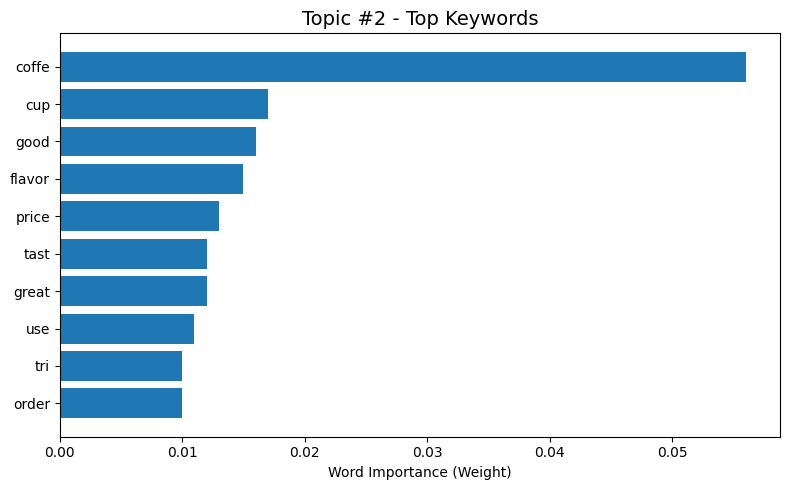

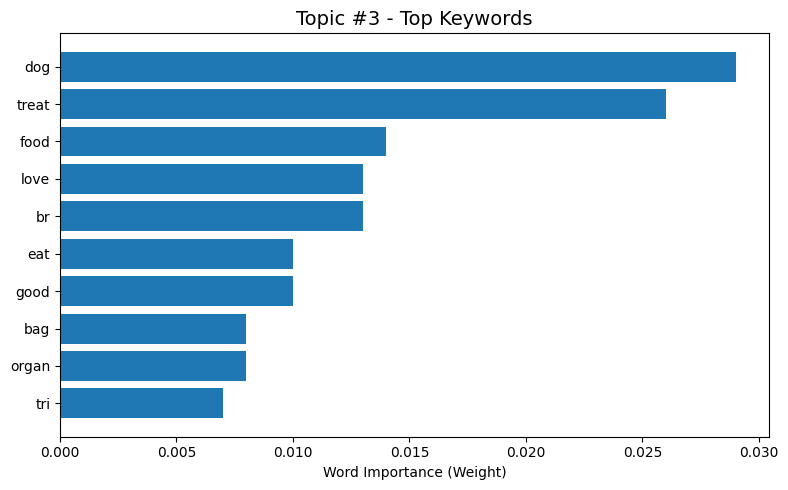

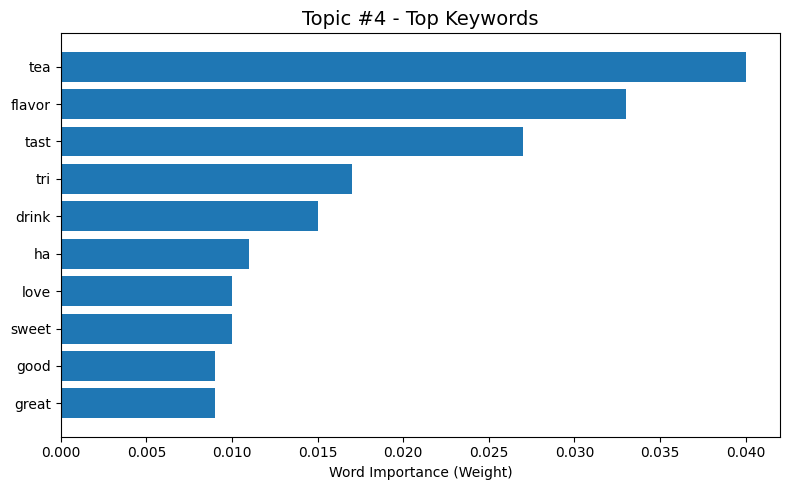

In [21]:
# Step: Bar Chart of Top Keywords per Topic
for i, topic in enumerate(topics):
    word_freq = {
        word.split("*")[1].strip().strip('"'): float(word.split("*")[0])
        for word in topic[1].split("+")
    }
    words = list(word_freq.keys())
    freqs = list(word_freq.values())

    plt.figure(figsize=(8, 5))
    plt.barh(words, freqs)
    plt.gca().invert_yaxis()  # Highest bar at top
    plt.title(f"Topic #{i} - Top Keywords", fontsize=14)
    plt.xlabel("Word Importance (Weight)")
    plt.tight_layout()
    plt.show()